# NSQIP Reproducibility Project
### Attempted Reproduction of "The combined risk predictive power of frailty and hypoalbuminemia in free tissue flap reconstruction: A cohort study of 34,571 patients from the NSQIP database" (Panayi et al., Microsurgery 2024)
### DOI:  10.1002/micr.31156

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency, fisher_exact
from scipy import stats
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import display

## *Excerpt from Methods (Panayi et al.)*

### Data source
The ACS-NSQIP database was utilized to identify patients who underwent free flap procedures during the period from 2008 to 2021. The ACS-NSQIP represents a nationally validated, risk-adjusted, and outcomes-focused database. It systemically collects patient data in a prospective, peer-controlled manner from more than 850 USA and international healthcare institutions. Overall, the database tracks 250 variables including patient demographics, comorbidities, and perioperative outcomes, among other variables. This study was approved
by the Institutional Review Board at Brigham and Women's Hospital (Protocol#: 2020P001675).

#### **1. Start by accessing 2008-2011 NSQIP data.**

In [2]:
df_08 = pd.read_csv("NSQIP_data/ACS_NSQIP_PUF08_TXT.txt", sep='\t', na_values=["NULL", -99], low_memory=False, encoding='latin1')
df_09 = pd.read_csv("NSQIP_data/ACS_NSQIP_PUF09_TXT.txt", sep='\t', na_values=["NULL", -99], low_memory=False, encoding='latin1')
df_10 = pd.read_csv("NSQIP_data/ACS_NSQIP_PUF10_TXT.txt", sep='\t', na_values=["NULL", -99], low_memory=False, encoding='latin1')
df_11 = pd.read_csv("NSQIP_data/ACS_NSQIP_PUF11_TXT.txt", sep='\t', na_values=["NULL", -99], low_memory=False, encoding='latin1')
df_12 = pd.read_csv("NSQIP_data/acs_nsqip_puf12.txt", sep='\t', na_values=["NULL", -99], low_memory=False, encoding='latin1')
df_13 = pd.read_csv("NSQIP_data/acs_nsqip_puf13.txt", sep='\t', na_values=["NULL", -99], low_memory=False, encoding='latin1')

In [3]:
df_14 = pd.read_csv("NSQIP_data/acs_nsqip_puf14.txt", sep='\t', na_values=["NULL", -99], low_memory=False, encoding='latin1')
df_15 = pd.read_csv("NSQIP_data/acs_nsqip_puf15_v2.txt", sep='\t', na_values=["NULL", -99], low_memory=False, encoding='latin1')
df_16 = pd.read_csv("NSQIP_data/acs_nsqip_puf16.txt", sep='\t', na_values=["NULL", -99], low_memory=False, encoding='latin1')
df_17 = pd.read_csv("NSQIP_data/acs_nsqip_puf17.txt", sep='\t', na_values=["NULL", -99], low_memory=False, encoding='latin1')
df_18 = pd.read_csv("NSQIP_data/acs_nsqip_puf18_v2.txt", sep='\t', na_values=["NULL", -99], low_memory=False, encoding='latin1')
df_19 = pd.read_csv("NSQIP_data/acs_nsqip_puf19.txt", sep='\t', na_values=["NULL", -99], low_memory=False, encoding='latin1')
df_20 = pd.read_csv("NSQIP_data/acs_nsqip_puf20.txt", sep='\t', na_values=["NULL", -99], low_memory=False, encoding='latin1')
df_21 = pd.read_csv("NSQIP_data/acs_nsqip_puf21.txt", sep='\t', na_values=["NULL", -99], low_memory=False, encoding='latin1')

In [4]:
datasets = [df_08, df_09, df_10, df_11, df_12, df_13, df_14, df_15, df_16, df_17, df_18, df_19, df_20, df_21]

## *Excerpt from Methods*

### Patient selection
Patients eligible for inclusion were identified through a manual screening
process involving “primary,” “concurrent,” and “other” current procedural terminology (CPT) codes, targeting microvascular free flap surgical procedures. The specific CPT codes examined were: 15756—free muscle or myocutaneous flap with microvascular anastomosis; 15,757—free skin flap with microvascular transfer; 15,758—free fascia flap with microvascular transfer; 15,842—graft for facial nerve paralysis, free muscle flap by microsurgical technique; 19,364—breast reconstruction with free flap;
19,367—breast reconstruction with transverse rectus abdominis myocutaneous flap (TRAM), single pedicle, including closure of donor site; 19,368—breast reconstruction with TRAM flap, single pedicle, including closure of donor site; with microvascular anastomosis; 19,369—breast reconstruction with TRAM flap, double pedicle, including closure of donor site; 20,955—bone graft with microvascular anastomosis, fibula; 20,956—bone graft with microvascular anastomosis, metatarsal; 20,957—bone graft with microvascular anastomosis; 20,962—bone graft with microvascular anastomosis; other bone graft; 20,969—free osteocutaneous flap with microvascular anastomosis, other than iliac crest, rib, metatarsal, or great toe; 20,970—free osteocutaneous flap with microvascular anastomosis, iliac crest; 20,972—free osteocutaneous flap with microvascular anastomosis, metatarsal; 20,973—free osteocutaneous flap with microvascular anastomosis, great toe with web space; 26,553—digit reconstruction with toe other than great toe; 26,554—digit reconstructions with toes other than great toe-double; 26,556—transfer, free toe joint with microvascular anastomosis.

#### 1. Select from CPT codes listed above

In [5]:
datasets = [df_08, df_09, df_10, df_11, df_12, df_13, df_14, df_15, df_16, df_17, df_18, df_19, df_20, df_21]
cpt_columns = [
    "CPT", "OTHERCPT1", "OTHERCPT2", "OTHERCPT3", "OTHERCPT4", "OTHERCPT5",
    "OTHERCPT6", "OTHERCPT7", "OTHERCPT8", "OTHERCPT9", "OTHERCPT10",
    "CONCPT1", "CONCPT2", "CONCPT3", "CONCPT4", "CONCPT5", "CONCPT6",
    "CONCPT7", "CONCPT8", "CONCPT9", "CONCPT10"
]


# Function to clean CPT codes
def clean_cpt(code):
    if pd.isnull(code):
        return ''
    code_str = str(code).strip().split('-')[0].split('.')[0]
    return code_str  

# Apply cleaning to all CPT columns in each dataset
for df in datasets:
    for col in cpt_columns:
        df[col] = df[col].apply(clean_cpt)

In [6]:
flap_codes = ['15756', '15757', '15758', '15842', '19364', '19367', '19368', 
              '19369', '20955', '20956', '20957', '20962', '20969', '20970', 
              '20972', '20973', '26553', '26554', '26556']

cpt_columns = [
    "CPT", "OTHERCPT1", "OTHERCPT2", "OTHERCPT3", "OTHERCPT4", "OTHERCPT5",
    "OTHERCPT6", "OTHERCPT7", "OTHERCPT8", "OTHERCPT9", "OTHERCPT10",
    "CONCPT1", "CONCPT2", "CONCPT3", "CONCPT4", "CONCPT5", "CONCPT6",
    "CONCPT7", "CONCPT8", "CONCPT9", "CONCPT10"
]


filtered_datasets = []

for df in datasets:
    
    mask_flap = df[cpt_columns].isin(flap_codes).any(axis=1)
    filtered_df = df[ mask_flap ].copy()
    filtered_datasets.append(filtered_df)

df_combined = pd.concat(filtered_datasets, axis=0)

In [7]:
print(f"There are {df_combined.shape[0]} free flap cases identified.")

There are 34913 free flap cases identified.


#### Reproduction Uncertainty
*After filtering by CPTs, Panayi et al. had 34,674 patients, whereas here we have 34,913 patients.*

#### Reproduction Uncertainty
*Though not described in the methods, the results include a stratification for free flaps for breast reconstruction.*

**Decision:**
Create a variable for whether or note the flap was for breast reconstruction

#### 2. Create breast binary column for whether or not the flap was for breast reconstruction 
- 19364—breast reconstruction with free flap;
- 19367—breast reconstruction with transverse rectus abdominis myocutaneous flap (TRAM), single pedicle, including closure of donor site; 
- 19368—breast reconstruction with TRAM flap, single pedicle, including closure of donor site; with microvascular anastomosis; 
- 19369—breast reconstruction with TRAM flap, double pedicle, including closure of donor site; 


In [8]:
breast_cpt = ['19364', '19367', '19368', '19369']
cpt_columns = [
    "CPT", "OTHERCPT1", "OTHERCPT2", "OTHERCPT3", "OTHERCPT4", "OTHERCPT5",
    "OTHERCPT6", "OTHERCPT7", "OTHERCPT8", "OTHERCPT9", "OTHERCPT10",
    "CONCPT1", "CONCPT2", "CONCPT3", "CONCPT4", "CONCPT5", "CONCPT6",
    "CONCPT7", "CONCPT8", "CONCPT9", "CONCPT10"
]

df_combined["BREASTFLAP_BINARY"] = np.where(
    df_combined[cpt_columns].isin(breast_cpt).any(axis=1),
    'Yes',                              
    'No'                                
)

df_combined.BREASTFLAP_BINARY.value_counts()

/tmp/ipykernel_556424/3831513231.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_combined["BREASTFLAP_BINARY"] = np.where(


BREASTFLAP_BINARY
Yes    23026
No     11887
Name: count, dtype: int64

## *Excerpt from Methods

### Patient Stratification
Based on the presence of at least one of the following comorbidities: hypertension, diabetes, congestive heart failure (CHF), chronic obstructive pulmonary disease (COPD), and functional status (dependent), patients were classified as frail using the mFI-5 score, a scale ranging from 1 to 5. Patients without these comorbidities were classified as nonfrail. Hypoalbuminemia was defined as a preoperative albumin levels of <3.5 g/dL.

*Figure 1a expands on the written methods, showing that Panayi et al. removed patients with missing functional status.*

#### Reproduction Uncertainty

*In 2008 - 2014 there are two functional status columns, FNSTATUS1 and FNSTATUS2 which describe functional status prior to current illness and prior to surgery respectively. From 2015-2021, there is only FNSTATUS2 (functional status prior to surgery).*

**Decision**: Will use this FNSTATUS2 column for consistency

#### 1. Select comorbidity variables

In [9]:
strat_cols = ["HYPERMED", "DIABETES", "HXCHF", "HXCOPD", "FNSTATUS2"]

for col in strat_cols:
    print(df_combined[col].value_counts())
    print(f"Number of NAs: {df_combined[col].isna().sum()}\n")

HYPERMED
No     24032
Yes    10881
Name: count, dtype: int64
Number of NAs: 0

DIABETES
NO             31807
NON-INSULIN     2184
INSULIN          873
ORAL              49
Name: count, dtype: int64
Number of NAs: 0

HXCHF
No     34792
Yes      121
Name: count, dtype: int64
Number of NAs: 0

HXCOPD
No     34086
Yes      827
Name: count, dtype: int64
Number of NAs: 0

FNSTATUS2
Independent            34342
Partially Dependent      422
Unknown                  104
Totally Dependent         45
Name: count, dtype: int64
Number of NAs: 0



#### 2. Drop patients with missing functional status

In [10]:
print(f"There are {sum( df_combined.FNSTATUS2 == 'Unknown')} cases with a missing functional status. These will be removed.")

df_combined.loc[df_combined.FNSTATUS2 == "Unknown", "FNSTATUS2"] = np.nan
num_fnstatus_missing = df_combined.FNSTATUS2.isna().sum()
df_combined = df_combined.dropna(subset="FNSTATUS2")

There are 104 cases with a missing functional status. These will be removed.


#### Reproduction Uncertainty
*Panayi et al. dropped 103 patients with missing functional status. Here 104 patients had missing functional status.*

#### 3. Clean comorbidity data columns for later analysis

In [11]:
df_combined = df_combined.copy()

#Add additional Diabetes and FNSTATUS2 in binary format for mFI-5 scoring
df_combined.loc[:,'DIABETES_BINARY'] = np.where(
    df_combined['DIABETES'] == "NO", 'No', 'Yes')

#FNSTATUS2_BINARY_NONIND will equal No if patient is independent, 
#and Yes is patient has this comorbidity (ie non-independent)
df_combined.loc[:,'FNSTATUS2_BINARY_NONIND'] = np.where(
    df_combined['FNSTATUS2'] == "Independent", 'No', 
    'Yes')

#### 4. Calculate mFI-5 score by summing comorbidities

In [12]:
mf_cols = ["HYPERMED", "DIABETES_BINARY", "HXCHF", "HXCOPD", "FNSTATUS2_BINARY_NONIND"]

df_combined.loc[:,'mFI-5'] = df_combined[mf_cols].eq("Yes").sum(axis=1)
df_combined['mFI-5'].value_counts()

mFI-5
0    22479
1     9562
2     2525
3      231
4       10
5        2
Name: count, dtype: int64

#### Reproduction Uncertainty

*Here there is a similar but not exact distribution in mFI-5 scores to Panayi et al.*


| mFI Score    | Panayi et al. | Reproduction |
| -------- | ------- | ------- |
| 0 | 22,363 | 22,479 |
| 1 | 9,466 | 9,562 |
| 2 | 2,505 | 2,525 |
| 3 | 226 | 231 |
| 4 | 9 | 10 |
| 5 | 2 | 2 |

## *Excerpt from Methods*

### Eligible variables
A range of pre, peri, and postoperative variables were extracted for analysis. These included demographic (sex, age, body mass index (BMI), and race), health, and comorbidity data (as defined by the mFI-5 score). BMI was calculated based on weight/(height * height)* 703. Of note, in the ACS-NSQIP database, sex and race are either self-assigned or assigned by personnel as per institutional practices. Sex is reported as male, female, and, more recently, nonbinary, whereas race is categorized as follows: American Indian or Alaska Native, Asian, Black or African American, Native Hawaiian or Pacific Islander, or White. Patient gender data are not included in the database. In addition, data on smoking (defined as smoking within the past year), type of diabetes therapy (oral or insulin), current dialysis, ventilator, or corticosteroid use were extracted. Further, the presence of
preoperative disseminated cancer, ascites, sepsis, bleeding disorder, or transfusion was determined. Preoperative blood values such as serum sodium, blood urea nitrogen (BUN), creatinine, serum albumin, total bilirubin, serum glutamic-oxaloacetic transaminase (SGOT), alkaline phosphatase (ALP), white blood cell count (WBC), hematocrit, platelet count, partial thromboplastin time (PTT), and international normalized ratio (INR) were also included in the analysis. Perioperative variables encompassed American Society of Anesthesiology (ASA) physical status (class 1–5), type of anesthesia (general, monitored anesthesia care, epidural/spinal, regional or other), elective or emergency surgery, setting (outpatient or inpatient), surgical specialty (otolaryngology, vascular, plastics, general surgery, gynecology, neurosurgery, orthopedics, thoracic, and urology), and year of surgery. The operative length (in minutes) was also included. Postoperative outcomes considered in this study were complications, total length of hospital stay (in days) and discharge destination (home, rehab, separate acute care, skilled care, and other facilities). Complications were limited to those occurring within 30 days postsurgery, as provided by the ACS-NSQIP, and classified into the following categories: any, surgical and medical. Any complication included mortality, medical or surgical complication, unplanned readmission, and reoperation. Surgical complications involved four types of wound healing disorder (superficial or deep incisional infection, organ space infection, dehiscence) and bleeding/transfusions. Medical complications encompassed pneumonia, unplanned reintubation, ventilator use for longer than 48 h, pulmonary embolism, urinary tract infection, cerebrovascular event or stroke with neurological deficit, cardiac arrest with cardiopulmonary resuscitation (CPR), myocardial infarction, deep vein thrombosis or thrombophlebitis, sepsis, or septicshock.


#### Reproduction Uncertainty
*Did not describe how to clasify obesity vs. underweight based on BMI*

***Decision:***
Will use CDC definitions:
- less than 18.5 is underweight
- greater than or equal to 30 is obese

#### 1. Calculate BMI and define BMI classes

In [13]:
df_combined = df_combined.copy()

df_combined['BMI'] = np.where(
    df_combined['HEIGHT'].isna() | df_combined['WEIGHT'].isna(), 
    pd.NA,  
    df_combined['WEIGHT'] / (df_combined['HEIGHT'] ** 2) * 703  # calculate BMI if data is available
)

df_combined['BMI_CLASS'] = np.where(
    df_combined['BMI'].isna(),  # Check if BMI is missing
    pd.NA,                     # Set to NaN if BMI is missing
    np.where(
        df_combined['BMI'] < 18.5,  # If BMI is less than 18.5
        'underweight',             # classify as underweight
        np.where(
            df_combined['BMI'] >= 30,  # If BMI is 30 or greater
            'obese',                   # classify as obese
            'normal'                   # otherwise, classify as normal
        )
    )
)

df_combined.BMI_CLASS.value_counts()

BMI_CLASS
normal         20930
obese          12972
underweight      694
Name: count, dtype: int64

In [14]:
#Set up OBESE_BINARY and UNDERWEIGHT_BINARY for eaiser univariate analysis
df_combined['OBESE_BINARY'] = np.where(
    df_combined['BMI_CLASS'].isna(),        # Check if BMI_CLASS is missing
    pd.NA,                                 # If missing, assign NA
    np.where(
        df_combined['BMI_CLASS'] == 'obese',  # Check if BMI_CLASS is "obese"
        'Yes',                              # If true, assign "Yes"
        'No'                                # Otherwise, assign "No"
    )
)

df_combined['UNDERWEIGHT_BINARY'] = np.where(
    df_combined['BMI_CLASS'].isna(),             # Check if BMI_CLASS is missing
    pd.NA,                                      # If missing, assign NA
    np.where(
        df_combined['BMI_CLASS'] == 'underweight', # Check if BMI_CLASS is "underweight"
        'Yes',                                   # If true, assign "Yes"
        'No'                                     # Otherwise, assign "No"
    )
)

print(df_combined.OBESE_BINARY.value_counts())
df_combined.UNDERWEIGHT_BINARY.value_counts()


OBESE_BINARY
No     21624
Yes    12972
Name: count, dtype: int64


UNDERWEIGHT_BINARY
No     33902
Yes      694
Name: count, dtype: int64

In [15]:
#Convert BMI and Age to numeric
df_combined['Age'] = pd.to_numeric(df_combined['Age'], errors='coerce')
df_combined['BMI'] = pd.to_numeric(df_combined['BMI'], errors='coerce')

#### 2. Clean diabets and diabetic therapy variables

In [16]:
#Set up DIABETIC_THERAPY column with "Oral" and "Insulin"
df_combined['DIABETES_THERAPY'] = np.where(
    df_combined['DIABETES'] == 'INSULIN',
    'Insulin',
    np.where(
        df_combined['DIABETES'].isin(['NON-INSULIN', 'ORAL']),
        'Oral',
        pd.NA  # Default to NaN for any other value (including missing values)
    )
)

print(df_combined['DIABETES'].value_counts())
print(df_combined['DIABETES_THERAPY'].value_counts())

DIABETES
NO             31714
NON-INSULIN     2176
INSULIN          870
ORAL              49
Name: count, dtype: int64
DIABETES_THERAPY
Oral       2225
Insulin     870
Name: count, dtype: int64


#### 3. Clean sepsis variable

In [17]:
#Set up SEPSIS_BINARY from PRSEPIS
#SIRS; Sepsis; Septic Shock; None
#No rows use the "None" qualifier. For this col only will use NAs. Noted below.

df_combined['SEPSIS_BINARY'] = np.where(
    df_combined['PRSEPIS'].isna(),
    'No',                              
    'Yes'                                
)


print(df_combined['PRSEPIS'].value_counts() )
df_combined['SEPSIS_BINARY'].value_counts()

PRSEPIS
SIRS            204
Sepsis           50
Septic Shock      3
Name: count, dtype: int64


SEPSIS_BINARY
No     34552
Yes      257
Name: count, dtype: int64

#### Reproduction Uncertainty
*The RACE_NEW variable has more options than are shown in the paper.*

**Decision:**
Will keep the RACE_NEW variables as is.

In [18]:
df_combined.RACE_NEW.value_counts()

RACE_NEW
White                                              22707
Unknown/Not Reported                                6063
Black or African American                           3973
Asian                                               1341
Unknown                                              400
American Indian or Alaska Native                     117
Native Hawaiian or Pacific Islander                   78
Some Other Race                                       57
Native Hawaiian or Other Pacific Islander             20
Asian,Some Other Race                                  4
Race combinations with low frequency                   2
White,Black or African American                        2
White,Asian                                            2
Native Hawaiian or Other Pacific Islander,Asian        1
Name: count, dtype: int64

## *Excerpt from Methods & Results*

### Statistics
Significance was set at p < .05 and p values were adjusted for multiple comparisons using the Bonferroni correction. Differences in categorical variables were assessed using a Chi-square test or Fisher's exact test in cases of expected counts less than five, whereas continuous variables were analyzed using one-way Analysis of Variance (ANOVA) and reported as means with standard deviations.

### Table 1. Patient Demographics and comorbidities

Broken down by mFI score
- Age: mean (SD)
- BMI: mean (SD)
- Sex: Female, Male
- Race: American Indian/Alaskan native, Asian, Native Hawaiian/Pacific Islander, Black/African American, White
- mFI-5 components: Diabetes, HTN, COPD, CHF, Funcational status (Independent, Dependent)
- Obesity
- Underweight
- Smoker
- Diabetic therapy (Oral, Insulin)
- Current dialysis
- Ventilator
- Steroid use
- Disseminated cancer
- Ascites
- Sepsis
- Bleeding disorder
- Preoperative transfusion




#### Reproduction Uncertainty

*What is the "total" for calculating percentages and statistics. Does it include or exclude patients with NA?*

*For example, the total number of Female / Male in the paper's table does not equal the total group n, but it does equal 100%.*
- For mFI score of 0 (n=22,363):
    - Female is 18,705 (83.67%)
    - Male is 3,651 (16.33%)
    
    - 18,705 + 3,651 = 22,356 which is 7 fewer than the total of 22,363. This means that 7 patients do not have Sex and were not included in the calculation. 
    
**Decision**:
    
Will follow above example of total does not include missing. 

The only column of issue is PRSEPIS which does not include a negative qualifier. Per documentation, it should be "None" however 0 cases include this. There is only SIRS, Sepsis, Septic Shock
- For this row only, will include NAs
    


In [19]:
cat_cols = ["SEX", "RACE_NEW", "DIABETES_BINARY", "HYPERMED", 
            "HXCOPD", "HXCHF", "FNSTATUS2_BINARY_NONIND", "OBESE_BINARY",
            "UNDERWEIGHT_BINARY", "SMOKE", "DIABETES_THERAPY",
            "DIALYSIS", "VENTILAT", "STEROID", "DISCANCR", 
            "ASCITES", "SEPSIS_BINARY", "BLEEDDIS", "TRANSFUS"]


for col in cat_cols:
    print(df_combined[col].value_counts())
    print(df_combined[col].isna().sum())
    print("\n")

SEX
female        27185
male           7611
non-binary        1
Name: count, dtype: int64
12


RACE_NEW
White                                              22707
Unknown/Not Reported                                6063
Black or African American                           3973
Asian                                               1341
Unknown                                              400
American Indian or Alaska Native                     117
Native Hawaiian or Pacific Islander                   78
Some Other Race                                       57
Native Hawaiian or Other Pacific Islander             20
Asian,Some Other Race                                  4
Race combinations with low frequency                   2
White,Black or African American                        2
White,Asian                                            2
Native Hawaiian or Other Pacific Islander,Asian        1
Name: count, dtype: int64
42


DIABETES_BINARY
No     31714
Yes     3095
Name: count, dtype: int64

#### 1. Create mFI groupings (4 and 5 are labelled as >4). Calculate the distribution of demographics and comorbidities across mFI. 

In [20]:
#Create mFI group variable (4 and 5 should be >4)
df_combined['mFI_GROUP'] = df_combined['mFI-5'].apply(lambda x: "≥4" if x >= 4 else str(int(x)))
mfi_order = ['0', '1', '2', '3', '≥4']

#start with continous variables
cont_cols = ["Age", "BMI"]

summary_rows = []
for var in cont_cols:
    row = {}
    row['Variable'] = f"{var}, mean (SD)"
    
    group_summaries = {}
    groups = df_combined.groupby('mFI_GROUP')
    
    group_series = []
    for grp in mfi_order:
        grp_data = groups.get_group(grp)[var] if grp in groups.groups else pd.Series([])
        count = grp_data.count()
        if count > 0:
            mean = grp_data.mean()
            sd = grp_data.std()
            group_summaries[grp] = f"{mean:.2f} ({sd:.2f})"
        else:
            group_summaries[grp] = "NA"
            
        if count > 0:
            group_series.append(grp_data.dropna())
            
    if len(group_series) > 1:
        f_stat, p_val = stats.f_oneway(*group_series)
    else:
        p_val = pd.NA
    
    
    row['p-value'] = p_val
    
    for grp in mfi_order:
        row[grp] = group_summaries.get(grp, "NA")
        
    summary_rows.append(row)

In [21]:
#Next do categorical columns
cat_cols = ["SEX", "RACE_NEW", "DIABETES_BINARY", "HYPERMED", 
            "HXCOPD", "HXCHF", "FNSTATUS2_BINARY_NONIND", "OBESE_BINARY",
            "UNDERWEIGHT_BINARY", "SMOKE", "DIABETES_THERAPY",
            "DIALYSIS", "VENTILAT", "STEROID", "DISCANCR", 
            "ASCITES", "SEPSIS_BINARY", "BLEEDDIS", "TRANSFUS"]

for var in cat_cols:

    levels = df_combined[var].dropna().unique()
    levels = np.sort(levels) 
    
    ct = pd.crosstab(df_combined['mFI_GROUP'], df_combined[var])
    
    p_val = pd.NA    
    try:
        chi2, p_val, dof, expected = stats.chi2_contingency(ct)
        
        if ct.shape == (2,2) and (expected < 5).any():
            _, fisher_p = stats.fisher_exact(ct)
            p_val = fisher_p
        
    except Exception as e:
        p_val = pd.NA
    
    for level in levels:
        row = {}
        row['Variable'] = f"{var}: {level}"

        group_summary = {}
        for grp in mfi_order:

            grp_df = df_combined[df_combined['mFI_GROUP'] == grp]
            n_grp = len(grp_df)

            cnt = grp_df[var].eq(level).sum()
            if n_grp > 0:
                perc = 100 * cnt / n_grp
                group_summary[grp] = f"{cnt} ({perc:.1f}%)"
            else:
                group_summary[grp] = "NA"
                
        row.update(group_summary)
        row['p-value'] = p_val
        summary_rows.append(row)
        
summary_df = pd.DataFrame(summary_rows)

#### 2. Format into table

In [22]:
# First, mark which rows correspond to an independent test.
# For continuous variables, the "Variable" string contains ", mean (SD)"
# For categorical variables, multiple rows share the same overall p-value.
# We will mark only the first occurrence (per variable) as independent.

# Start by creating a Boolean mask for continuous tests.
indep_mask = summary_df['Variable'].str.contains(r', mean \(SD\)')

# For categorical rows (those not matching continuous tests), we need to pick one row per variable.
cat_mask = ~indep_mask
# For these rows, the variable name should be everything before the colon.
# (Some binary rows may not have a colon; in that case, we treat the entire string as the variable name.)
cat_vars = summary_df.loc[cat_mask, 'Variable'].apply(
    lambda x: x.split(": ")[0] if ": " in x else x
)

# For each categorical variable, pick the first row as the independent test.
first_cat_indices = cat_vars.groupby(cat_vars).apply(lambda idx: idx.index[0])
# Mark these rows as independent.
indep_mask.loc[first_cat_indices] = True

# Now, extract p-values only from the independent tests.
p_vals_indep = summary_df.loc[indep_mask, 'p-value'].dropna().astype(float).values

# Perform Bonferroni correction on the independent tests.
if len(p_vals_indep) > 0:
    reject, p_adj, alphacSidak, alphacBonf = multipletests(p_vals_indep, alpha=0.05, method='bonferroni')
    # Update the p-values for the independent tests.
    summary_df.loc[indep_mask, 'p-value'] = p_adj

    # Next, for the categorical variables, propagate the adjusted p-value from the independent row
    # to all rows corresponding to that variable.
    # For the rows in cat_mask, get the variable name as before.
    cat_vars_all = summary_df.loc[cat_mask, 'Variable'].apply(
        lambda x: x.split(": ")[0] if ": " in x else x
    )
    for var in cat_vars_all.unique():
        # Create a mask for all rows (both header and level rows) belonging to this variable.
        var_mask = summary_df['Variable'].apply(
            lambda x: x.split(": ")[0] if ": " in x else x
        ) == var
        # Get the adjusted p-value from the independent (first) row for this variable.
        adjusted = summary_df.loc[var_mask, 'p-value'].iloc[0]
        # Propagate it to all rows for that variable.
        summary_df.loc[var_mask, 'p-value'] = adjusted

# Finally, reorder the columns if needed.
cols = ['Variable'] + mfi_order + ['p-value']
summary_df = summary_df[cols]


In [23]:
# Define the mFI order and column order.
mfi_order = ['0', '1', '2', '3', '≥4']
cols_order = ['Variable'] + mfi_order + ['p-value']

# List of binary categorical variables for which we want to display only one (merged) row.
binary_vars = [
    "DIABETES_BINARY", "HYPERMED", "HXCOPD", "HXCHF", "OBESE_BINARY",
    "UNDERWEIGHT_BINARY", "SMOKE", "DIALYSIS", "VENTILAT", "STEROID",
    "DISCANCR", "ASCITES", "SEPSIS_BINARY", "BLEEDDIS", "TRANSFUS"
]

# ============================================================================
# STEP 1. Separate continuous and categorical rows.
# (Continuous rows have ", mean (SD)" in their 'Variable' text.)
# ============================================================================
mask_cont = summary_df['Variable'].str.contains(r',\s*mean\s*\(SD\)', regex=True)
cont_df = summary_df.loc[mask_cont].copy()
cat_df = summary_df.loc[~mask_cont].copy()

# ============================================================================
# STEP 2. Split categorical rows into variable name (cat) and level when possible.
#
# Some rows (typically for binary variables) might already be merged
# (e.g., "DIABETES_BINARY" with no colon). In those cases, we leave them as is.
# ============================================================================
def split_var(val):
    if isinstance(val, str) and ": " in val:
        cat, level = val.split(": ", 1)
    else:
        cat, level = val, None
    return pd.Series({'cat': cat, 'level': level})

# Apply the splitting and join the results as new columns.
cat_df = cat_df.copy()
cat_df = cat_df.join(cat_df['Variable'].apply(split_var))

# ============================================================================
# STEP 3. Rebuild the formatted table.
#
# For binary variables (in binary_vars):
#   - If there is a split version (i.e. the row has a non-null level),
#     select the row for which level=="Yes" if available (otherwise, use the first row).
#   - Use the merged row (with the variable name) and leave its p-value intact.
#
# For non-binary variables:
#   - Create a header row showing the variable name and p-value.
#   - Then add one row per level (showing just the level and a blank p-value).
# ============================================================================
formatted_rows = []

# (A) Add continuous rows as they are.
for _, row in cont_df.iterrows():
    formatted_rows.append(row[cols_order].to_dict())

# (B) Process categorical rows, grouped by the variable name.
for cat_name, group in cat_df.groupby('cat', sort=False):
    if cat_name in binary_vars:
        # For binary variables, check if the rows were split (i.e. have non-null 'level')
        if group['level'].notna().any():
            # Look for the row corresponding to "Yes"
            bin_group = group[group['level'] == "Yes"]
            if not bin_group.empty:
                row = bin_group.iloc[0].copy()
            else:
                row = group.iloc[0].copy()
        else:
            # If no split was possible, use the row as is.
            row = group.iloc[0].copy()
        # Ensure that the "Variable" cell shows only the variable name.
        row['Variable'] = cat_name
        formatted_rows.append(row[cols_order].to_dict())
    else:
        # For non-binary variables, create a header row showing the variable name and p-value.
        header_row = {col: "" for col in cols_order}
        header_row['Variable'] = cat_name
        header_row['p-value'] = group['p-value'].iloc[0]
        formatted_rows.append(header_row)
        
        # Now add one row per level (only for rows that were split).
        for idx, row in group.iterrows():
            if pd.notnull(row['level']):
                new_row = {col: row[col] for col in cols_order}
                # Replace the "Variable" cell with just the level.
                new_row['Variable'] = row['level']
                # Blank out the p-value in the breakdown rows.
                new_row['p-value'] = ""
                formatted_rows.append(new_row)

# Build the final DataFrame.
formatted_df = pd.DataFrame(formatted_rows, columns=cols_order)

# ============================================================================
# STEP 4. Format the display using Pandas Styler.
#
# We want:
#  - Bold header rows (for non-binary variables) and left-align them.
#  - Binary variable rows left-aligned.
#  - All other rows remain center-aligned (set globally).
# ============================================================================
def style_row(row):
    """
    Returns a list of CSS style strings for the row.
    
    - If the row is a header for a non-binary categorical variable (i.e. its 'Variable'
      equals one of the categorical variable names but is not in binary_vars), then
      bold and left-align.
    - If the row is a binary variable row (its 'Variable' is in binary_vars), then
      left-align.
    - Otherwise, return an empty string (so the global center alignment applies).
    """
    var = row['Variable']
    if (var in set(cat_df['cat'].unique())) and (var not in set(binary_vars)):
        # Bold and left align header rows for non-binary variables.
        return ['font-weight: bold; text-align: left;'] * len(row)
    elif var in set(binary_vars):
        # Left-align binary variable rows.
        return ['font-weight: bold; text-align: left;'] * len(row)
    else:
        return [''] * len(row)

# Build the styled table.
try:
    styled_table = (formatted_df.style
                    .apply(style_row, axis=1)
                    .set_caption("Summary Table")
                    .set_properties(**{'text-align': 'center'})
                    .hide(axis='index'))
except Exception:
    styled_table = (formatted_df.style
                    .apply(style_row, axis=1)
                    .set_caption("Summary Table")
                    .set_properties(**{'text-align': 'center'}))

# ============================================================================
# STEP 5. Display the table in Jupyter Notebook.
# ============================================================================
display(styled_table)


Variable,0,1,2,3,≥4,p-value
"Age, mean (SD)",50.65 (11.54),59.02 (11.33),62.65 (10.66),68.60 (10.27),74.60 (8.55),0.000000
"BMI, mean (SD)",28.22 (5.70),29.55 (6.39),30.52 (6.96),29.20 (7.94),28.45 (9.08),0.000000
SEX,,,,,,0.000000
female,18765 (83.5%),6807 (71.2%),1505 (59.6%),106 (45.9%),2 (16.7%),
male,3707 (16.5%),2751 (28.8%),1018 (40.3%),125 (54.1%),10 (83.3%),
non-binary,1 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),
RACE_NEW,,,,,,0.000000
American Indian or Alaska Native,70 (0.3%),30 (0.3%),14 (0.6%),3 (1.3%),0 (0.0%),
Asian,928 (4.1%),307 (3.2%),98 (3.9%),8 (3.5%),0 (0.0%),
"Asian,Some Other Race",3 (0.0%),1 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),


## *Excerpt from Results*

### Table 2. Surgical characteristics.

Stratified by mFI score, variables incldue:
- Type of anesthesia
- Elective
- Emergency
- Inpatient / outpatient
- Specialty
- Breast flap 
- Year of surgery

#### Reproduction Uncertainty
ELECTSURG variable for elective surgery started in 2011 whereas this Panayi et al. is exploring all data starting in 2008. 

**Decision**:
ELECTSURG will still be used and cases from prior to 2011 will not be elective. This has the potential to add signficant bias to the analysis.

#### 1. Clean demographic data

In [24]:
demo_cols = ["ASACLAS", "ANESTHES", "ELECTSURG", "EMERGNCY", "INOUT",
            "SURGSPEC", "BREASTFLAP_BINARY", "OperYR"]

In [25]:
#clean demo_cols

for col in demo_cols:
    print(df_combined[col].value_counts())
    print(df_combined[col].isna().sum())

ASACLAS
2-Mild Disturb      17783
3-Severe Disturb    14805
1-No Disturb         1280
4-Life Threat         908
None assigned          28
5-Moribund              4
Name: count, dtype: int64
1
ANESTHES
General                      34665
MAC/IV Sedation                 47
Spinal                          32
Regional                        27
Other                           12
Epidural                         9
Local                            4
Unknown                          4
Monitored Anesthesia Care        2
Name: count, dtype: int64
7
ELECTSURG
Yes        27202
No           997
Unknown       12
Name: count, dtype: int64
6598
EMERGNCY
No     30312
Yes      112
Name: count, dtype: int64
4385
INOUT
Inpatient     32970
Outpatient     1839
Name: count, dtype: int64
0
SURGSPEC
Plastics                19961
Otolaryngology (ENT)     7317
General Surgery          6426
Orthopedics               760
Neurosurgery              197
Gynecology                 53
Vascular                   47
Thora

In [26]:
#clean demo_cols
df_combined.loc[df_combined['ASACLAS'] == "None assigned", 'ASACLAS'] = pd.NA
df_combined.loc[df_combined['ANESTHES'] == "Unknown", 'ANESTHES'] = pd.NA
df_combined.loc[df_combined['ELECTSURG'] == "Unknown", 'ELECTSURG'] = pd.NA

#### 2. Calculate distribution of demographic data across mFI scores

In [27]:
summary_rows = []
mfi_order = ['0', '1', '2', '3', '≥4']


# Number of tests is the number of variables in demo_cols
n_tests = len(demo_cols)

for var in demo_cols:
    # Get the unique, non-missing levels for the variable, sorted for consistency
    levels = np.sort(df_combined[var].dropna().unique())
    
    # Create a contingency table between 'mFI_GROUP' and the current variable
    ct = pd.crosstab(df_combined['mFI_GROUP'], df_combined[var])
    
    p_val = pd.NA    
    try:
        # Run the chi-square test
        chi2, p_val, dof, expected = stats.chi2_contingency(ct)
        
        # For 2x2 tables, if any expected count is less than 5, use Fisher’s exact test instead.
        if ct.shape == (2, 2) and (expected < 5).any():
            _, fisher_p = stats.fisher_exact(ct)
            p_val = fisher_p
        
    except Exception as e:
        p_val = pd.NA

    # Apply the Bonferroni correction: multiply p_val by the number of tests,
    # but cap it at 1.0 so it does not exceed 100%
    if pd.notna(p_val):
        p_val_corrected = min(p_val * n_tests, 1.0)
    else:
        p_val_corrected = pd.NA

    # For reporting, loop through each level of the variable.
    # (Note: The overall test p-value applies to the entire variable,
    # so it is repeated for every level in this table.)
    for level in levels:
        row = {}
        row['Variable'] = f"{var}: {level}"

        # Calculate counts and percentages for each group in mFI_GROUP
        for grp in mfi_order:
            grp_df = df_combined[df_combined['mFI_GROUP'] == grp]
            n_grp = len(grp_df)
            cnt = grp_df[var].eq(level).sum()
            if n_grp > 0:
                perc = 100 * cnt / n_grp
                row[grp] = f"{cnt} ({perc:.1f}%)"
            else:
                row[grp] = "NA"
                
        # Store the Bonferroni-corrected p-value
        row['p-value'] = p_val_corrected
        summary_rows.append(row)

# Create a DataFrame from the summary rows.
summary_df = pd.DataFrame(summary_rows)


#### 3. Format table

In [28]:
import pandas as pd
import numpy as np
from IPython.display import display

# Define the mFI order and column order.
mfi_order = ['0', '1', '2', '3', '≥4']
cols_order = ['Variable'] + mfi_order + ['p-value']

# List of binary categorical variables for which we want to display only one (merged) row.
binary_vars = ["ELECTSURG", "EMERGNCY", "SURGSPEC"]

# ============================================================================
# STEP 1. Separate continuous and categorical rows.
# (Continuous rows have ", mean (SD)" in their 'Variable' text.)
# ============================================================================
mask_cont = summary_df['Variable'].str.contains(r',\s*mean\s*\(SD\)', regex=True)
cont_df = summary_df.loc[mask_cont].copy()
cat_df = summary_df.loc[~mask_cont].copy()

# ============================================================================
# STEP 2. Split categorical rows into variable name (cat) and level when possible.
#
# Some rows (typically for binary variables) might already be merged
# (e.g., "DIABETES_BINARY" with no colon). In those cases, we leave them as is.
# ============================================================================
def split_var(val):
    if isinstance(val, str) and ": " in val:
        cat, level = val.split(": ", 1)
    else:
        cat, level = val, None
    return pd.Series({'cat': cat, 'level': level})

# Apply the splitting and join the results as new columns.
cat_df = cat_df.copy()
cat_df = cat_df.join(cat_df['Variable'].apply(split_var))

# ============================================================================
# STEP 3. Rebuild the formatted table.
#
# For binary variables (in binary_vars):
#   - If there is a split version (i.e. the row has a non-null level),
#     select the row for which level=="Yes" if available (otherwise, use the first row).
#   - Use the merged row (with the variable name) and leave its p-value intact.
#
# For non-binary variables:
#   - Create a header row showing the variable name and p-value.
#   - Then add one row per level (showing just the level and a blank p-value).
# ============================================================================
formatted_rows = []

# (A) Add continuous rows as they are.
for _, row in cont_df.iterrows():
    formatted_rows.append(row[cols_order].to_dict())

# (B) Process categorical rows, grouped by the variable name.
for cat_name, group in cat_df.groupby('cat', sort=False):
    if cat_name in binary_vars:
        # For binary variables, check if the rows were split (i.e. have non-null 'level')
        if group['level'].notna().any():
            # Look for the row corresponding to "Yes"
            bin_group = group[group['level'] == "Yes"]
            if not bin_group.empty:
                row = bin_group.iloc[0].copy()
            else:
                row = group.iloc[0].copy()
        else:
            # If no split was possible, use the row as is.
            row = group.iloc[0].copy()
        # Ensure that the "Variable" cell shows only the variable name.
        row['Variable'] = cat_name
        formatted_rows.append(row[cols_order].to_dict())
    else:
        # For non-binary variables, create a header row showing the variable name and p-value.
        header_row = {col: "" for col in cols_order}
        header_row['Variable'] = cat_name
        header_row['p-value'] = group['p-value'].iloc[0]
        formatted_rows.append(header_row)
        
        # Now add one row per level (only for rows that were split).
        for idx, row in group.iterrows():
            if pd.notnull(row['level']):
                new_row = {col: row[col] for col in cols_order}
                # Replace the "Variable" cell with just the level.
                new_row['Variable'] = row['level']
                # Blank out the p-value in the breakdown rows.
                new_row['p-value'] = ""
                formatted_rows.append(new_row)

# Build the final DataFrame.
formatted_df = pd.DataFrame(formatted_rows, columns=cols_order)

# ============================================================================
# STEP 4. Format the display using Pandas Styler.
#
# We want:
#  - Bold header rows (for non-binary variables) and left-align them.
#  - Binary variable rows left-aligned.
#  - All other rows remain center-aligned (set globally).
# ============================================================================
def style_row(row):
    """
    Returns a list of CSS style strings for the row.
    
    - If the row is a header for a non-binary categorical variable (i.e. its 'Variable'
      equals one of the categorical variable names but is not in binary_vars), then
      bold and left-align.
    - If the row is a binary variable row (its 'Variable' is in binary_vars), then
      left-align.
    - Otherwise, return an empty string (so the global center alignment applies).
    """
    var = row['Variable']
    if (var in set(cat_df['cat'].unique())) and (var not in set(binary_vars)):
        # Bold and left align header rows for non-binary variables.
        return ['font-weight: bold; text-align: left;'] * len(row)
    elif var in set(binary_vars):
        # Left-align binary variable rows.
        return ['font-weight: bold; text-align: left;'] * len(row)
    else:
        return [''] * len(row)

# Build the styled table.
try:
    styled_table = (formatted_df.style
                    .apply(style_row, axis=1)
                    .set_caption("Summary Table")
                    .set_properties(**{'text-align': 'center'})
                    .hide(axis='index'))
except Exception:
    styled_table = (formatted_df.style
                    .apply(style_row, axis=1)
                    .set_caption("Summary Table")
                    .set_properties(**{'text-align': 'center'}))

# ============================================================================
# STEP 5. Display the table in Jupyter Notebook.
# ============================================================================
display(styled_table)


Variable,0,1,2,3,≥4,p-value
ASACLAS,,,,,,0.000000
1-No Disturb,1225 (5.4%),51 (0.5%),3 (0.1%),1 (0.4%),0 (0.0%),
2-Mild Disturb,13484 (60.0%),3844 (40.2%),438 (17.3%),16 (6.9%),1 (8.3%),
3-Severe Disturb,7486 (33.3%),5308 (55.5%),1852 (73.3%),153 (66.2%),6 (50.0%),
4-Life Threat,263 (1.2%),353 (3.7%),226 (9.0%),61 (26.4%),5 (41.7%),
5-Moribund,0 (0.0%),1 (0.0%),3 (0.1%),0 (0.0%),0 (0.0%),
ANESTHES,,,,,,0.110766
Epidural,8 (0.0%),0 (0.0%),0 (0.0%),1 (0.4%),0 (0.0%),
General,22389 (99.6%),9528 (99.6%),2509 (99.4%),227 (98.3%),12 (100.0%),
Local,2 (0.0%),1 (0.0%),1 (0.0%),0 (0.0%),0 (0.0%),


## *Excerpt from Results*

### Table 3 Preoperative Lab Values
Stratified across mFI, variables included:
- Serum sodium
- BUN
- Creatinine
- Serum albumin
- Total bilirubin
- SGOT
- ALP
- WBC
- Hematocrit
- Platelet count
- PTT
- INR

#### 1. Select laboratory variables

In [29]:
labs_cols = ["PRSODM", "PRBUN", "PRCREAT", "PRALBUM","PRBILI", "PRSGOT", "PRALKPH",
            "PRWBC", "PRHCT", "PRPLATE", "PRPTT", "PRINR"]

In [30]:
#look at labs_cols
for col in labs_cols:
    print(f"{col} has {df_combined[col].isna().sum()} NAs")

PRSODM has 6401 NAs
PRBUN has 8302 NAs
PRCREAT has 5767 NAs
PRALBUM has 18397 NAs
PRBILI has 18981 NAs
PRSGOT has 19015 NAs
PRALKPH has 18678 NAs
PRWBC has 4532 NAs
PRHCT has 4177 NAs
PRPLATE has 4522 NAs
PRPTT has 24347 NAs
PRINR has 22497 NAs


#### 2. Stratify across mFI scores

In [31]:
mfi_order = ['0', '1', '2', '3', '≥4']

# This will store the summary rows for the continuous variables table.
summary_rows_cont = []

# The number of tests is the number of continuous variables.
n_tests = len(labs_cols)

for var in labs_cols:
    row = {}
    row['Variable'] = var
    group_values = []  # to hold data for the statistical test
    
    # For each group in mfi_order, compute mean (sd)
    for grp in mfi_order:
        # Select the data for the current group and variable; drop missing values.
        grp_data = df_combined.loc[df_combined['mFI_GROUP'] == grp, var].dropna()
        if len(grp_data) > 0:
            mean_val = grp_data.mean()
            std_val = grp_data.std()
            # Format as "mean (sd)" with two decimals
            row[grp] = f"{mean_val:.2f} ({std_val:.2f})"
        else:
            row[grp] = "NA"
        group_values.append(grp_data)
    
    # Initialize p-value
    p_val = pd.NA
    
    try:
        # If there are exactly two groups, use an independent t-test.
        if len(mfi_order) == 2:
            stat, p_val = stats.ttest_ind(group_values[0], group_values[1], nan_policy='omit')
        # If more than two groups, use one-way ANOVA.
        elif len(mfi_order) > 2:
            stat, p_val = stats.f_oneway(*group_values)
    except Exception as e:
        p_val = pd.NA

    # Apply Bonferroni correction by multiplying the raw p-value by the number of tests.
    # Cap the corrected p-value at 1.0.
    if pd.notna(p_val):
        p_val_corrected = min(p_val * n_tests, 1.0)
    else:
        p_val_corrected = pd.NA
        
    row['p-value'] = p_val_corrected
    summary_rows_cont.append(row)

# Create the summary DataFrame.
summary_df_cont = pd.DataFrame(summary_rows_cont)
summary_df_cont


,Variable,0,1,2,3,≥4,p-value
0,PRSODM,139.69 (2.61),139.23 (3.10),138.54 (3.57),138.14 (3.42),136.17 (3.49),1.630603e-98
1,PRBUN,13.84 (5.59),15.63 (7.32),17.70 (9.94),20.13 (10.61),20.28 (10.86),1.019490e-212
2,PRCREAT,0.78 (0.28),0.86 (0.41),0.98 (0.72),1.02 (0.59),0.97 (0.42),4.789650e-176
3,PRALBUM,4.14 (0.45),4.07 (0.50),3.95 (0.57),3.64 (0.64),3.16 (1.06),7.679280e-79
4,PRBILI,0.49 (0.44),0.52 (0.36),0.51 (0.40),0.62 (1.25),0.63 (0.24),1.791441e-03
5,PRSGOT,24.11 (15.70),25.19 (21.38),25.01 (19.02),21.68 (8.61),23.29 (6.65),3.808911e-02
6,PRALKPH,79.32 (32.21),82.95 (33.95),86.83 (42.58),89.02 (40.68),71.71 (13.72),5.156810e-17
7,PRWBC,6.62 (2.50),7.14 (2.65),7.77 (2.98),8.55 (3.38),8.13 (1.89),3.428835e-135
8,PRHCT,39.24 (4.06),39.11 (4.63),38.23 (5.07),36.92 (6.33),34.93 (6.98),1.036905e-36
9,PRPLATE,256.68 (72.45),260.75 (78.71),262.85 (86.71),267.42 (90.47),237.58 (102.04),5.602834e-05


## *Excerpt from Methods & Results*
Any complication included mortality, medical or surgical complication, unplanned readmission, and reoperation. Surgical complications involved four types of wound healing disorder (superficial or deep incisional infection, organ space infection, dehiscence) and bleeding/transfusions. Medical complications encompassed pneumonia, unplanned reintubation, ventilator use for longer than 48 h, pulmonary embolism, urinary tract infection, cerebrovascular event or stroke with neurological deficit, cardiac arrest with cardiopulmonary resuscitation (CPR), myocardial infarction, deep vein thrombosis or thrombophlebitis, sepsis, or septic shock.

### Table 4: Perioperative Outcomes



- hospital stay
- operative time (mins)
- mortality
- reoperation
- unplanned readmission
- superficial incisional infection
- deep incisional wound infection
- organ space infection
- dehiscence
- bleeding transfusions
- pneumonia
- reintubation
- PE
- ventilator >48h
- acute renal failure
- urinary tract infection
- CVA/stroke, neurological deficit
- cardiac arrest requiring CPR
- MI
- DVT / thrombophlebititis
- sepsis
- septic shock
- dishcarge destination

#### Reproduction Uncertainty
*There is not a mortality column.*

**Decision:** Will use presence of the variable, "DOpertoD" which is days from operation to death.


#### Reproduction Uncertainty
*From 2008 - 2010 there is only a "RETURNOR" which includes both planned and unplanned reoperation. In 2011, unplanned reoperations were specified.*

**Decision:** Will use RETURNOR for consistency


#### Reproduction Uncertainty
*UNPLANREADMISSION was introduced in 2011, in 2015 changed to UNPLANNEDREADMISSION1 and numbered after that.*

**Decision:** Will create new binary variable for either UNPLANREADMISSION or UNPLANNEDREADMISSION1


#### Reproduction Uncertainty
*DISCHDEST was introduced in 2011, whereas this analysis includes data from 2008. There are more possible discharge locations than shown in the Panayi et al.*

**Decision:** Will keep DISCHDEST although this may add additional bias

#### 1. Clean outcome variables based on above decisions

In [32]:
#Create Mortality column
df_combined["MORTALITY_BINARY"] = np.where(
    df_combined.DOpertoD.isna(), 'No', 'Yes'
)

In [33]:
df_combined.UNPLANNEDREADMISSION1.value_counts()

UNPLANNEDREADMISSION1
Yes    2097
No      125
Name: count, dtype: int64

In [34]:
#Create UNPLANREADMISSION_BINARY column
readmin_cols = ["UNPLANREADMISSION", "UNPLANNEDREADMISSION1"]

df_combined["UNPLANREADMISSION_BINARY"] = np.where(
    df_combined[readmin_cols].isna().all(axis=1),
    pd.NA,
    np.where(
        df_combined[readmin_cols].eq("Yes").any(axis=1),
        "Yes",
        "No"
    )
)


In [35]:
periop_cont_cols = ["TOTHLOS", "OPTIME"]
og_periop_cat_cols = ["MORTALITY_BINARY", "RETURNOR", "UNPLANNEDREADMISSION1",
                  "SUPINFEC", "WNDINFD", "ORGSPCSSI", "DEHIS", 
                   "OTHBLEED", "OUPNEUMO", "REINTUB", "PULEMBOL", "FAILWEAN",
                  "OPRENAFL", "URNINFEC", "CNSCVA", "CDARREST", "CDMI",
                  "OTHDVT", "OTHSYSEP", "OTHSESHOCK", "DISCHDEST"]

In [36]:
#look at cols
for col in periop_cont_cols:
    print(f"{col} has {df_combined[col].isna().sum()} NAs")

for col in og_periop_cat_cols:
    print("\n")
    print(df_combined[col].value_counts())
    print(df_combined[col].isna().sum())

TOTHLOS has 232 NAs
OPTIME has 16 NAs


MORTALITY_BINARY
No     34704
Yes      105
Name: count, dtype: int64
0


RETURNOR
No     30139
Yes     4670
Name: count, dtype: int64
0


UNPLANNEDREADMISSION1
Yes    2097
No      125
Name: count, dtype: int64
32587


SUPINFEC
No Complication               32899
Superficial Incisional SSI     1910
Name: count, dtype: int64
0


WNDINFD
No Complication        34075
Deep Incisional SSI      734
Name: count, dtype: int64
0


ORGSPCSSI
No Complication    34294
Organ/Space SSI      515
Name: count, dtype: int64
0


DEHIS
No Complication     33827
Wound Disruption      982
Name: count, dtype: int64
0


OTHBLEED
No Complication                29987
Transfusions/Intraop/Postop     4803
Bleeding/Transfusions             19
Name: count, dtype: int64
0


OUPNEUMO
No Complication    34154
Pneumonia            655
Name: count, dtype: int64
0


REINTUB
No Complication         34526
Unplanned Intubation      283
Name: count, dtype: int64
0


PULEMBOL
No Complica

In [37]:
#clean cols
nocomp_cols = ["SUPINFEC", "WNDINFD", "ORGSPCSSI", "DEHIS", 
                   "OTHBLEED", "OUPNEUMO", "REINTUB", "PULEMBOL", "FAILWEAN",
                  "OPRENAFL", "URNINFEC", "CNSCVA", "CDARREST", "CDMI",
                  "OTHDVT", "OTHSYSEP", "OTHSESHOCK"]

for col in nocomp_cols:
    assert df_combined[col].isna().sum() == 0
    
    df_combined[f"{col}_BINARY"] = np.where(
        df_combined[col] == "No Complication",
        "No",
        "Yes"
    )
    
    
df_combined.loc[df_combined['DISCHDEST'] == "Unknown", 'DISCHDEST'] = pd.NA

#### 2. Create groupings of "any complication", "surgical complication", and "medical complication"

In [38]:
#create any complication, surgical complication, and medical complication
df_combined = df_combined.copy()

#surgical
surg_comp_cols = ["SUPINFEC_BINARY", "WNDINFD_BINARY", "ORGSPCSSI_BINARY",
                  "DEHIS_BINARY", "OTHBLEED_BINARY"]

df_combined["SURGCOMP"] = np.where(
    df_combined[surg_comp_cols].eq("Yes").any(axis=1),
    "Yes",
    "No"
)



#medical
med_comp_cols = ["OUPNEUMO_BINARY",
                       "REINTUB_BINARY", "PULEMBOL_BINARY", "FAILWEAN_BINARY",
                  "OPRENAFL_BINARY", "URNINFEC_BINARY", "CNSCVA_BINARY", 
                       "CDARREST_BINARY", "CDMI_BINARY", "OTHDVT_BINARY",
                       "OTHSYSEP_BINARY", "OTHSESHOCK_BINARY"]
df_combined["MEDCOMP"] = np.where(
    df_combined[med_comp_cols].eq("Yes").any(axis=1),
    "Yes",
    "No"
)

#any
any_comp_cols = ["SURGCOMP", "MEDCOMP", "UNPLANREADMISSION_BINARY", "RETURNOR"]
df_combined["ANYCOMP"] = np.where(
    df_combined[any_comp_cols].eq("Yes").any(axis=1),
    "Yes",
    "No"
)

#### 3. Stratify by mFI

In [39]:
mfi_order = ['0', '1', '2', '3', '≥4']

periop_cont_cols = ["TOTHLOS", "OPTIME"]
new_periop_cat_cols = [
    "ANYCOMP", "MORTALITY_BINARY", "RETURNOR", "UNPLANREADMISSION_BINARY",
    "SURGCOMP",
    "SUPINFEC_BINARY", "WNDINFD_BINARY", "ORGSPCSSI_BINARY", "DEHIS_BINARY", "OTHBLEED_BINARY", 
    "MEDCOMP",
    "OUPNEUMO_BINARY", "REINTUB_BINARY", "PULEMBOL_BINARY", "FAILWEAN_BINARY",
    "OPRENAFL_BINARY", "URNINFEC_BINARY", "CNSCVA_BINARY", 
    "CDARREST_BINARY", "CDMI_BINARY", "OTHDVT_BINARY",
    "OTHSYSEP_BINARY", "OTHSESHOCK_BINARY",
    "DISCHDEST"
]

# Total number of tests for Bonferroni correction.
n_tests = len(periop_cont_cols) + len(new_periop_cat_cols)

# This list will collect all summary rows.
summary_rows = []

# ============================================================================
# STEP A: Process continuous variables.
# For these, we compute mean (SD) by mFI_GROUP and perform one-way ANOVA.
# We append ", mean (SD)" to the variable name so we can later identify these rows.
# ============================================================================
for var in periop_cont_cols:
    row = {}
    # Append tag so that continuous rows are easily recognized.
    row['Variable'] = f"{var}, mean (SD)"
    group_data = []  # to collect data arrays for ANOVA

    # For each group in mfi_order, compute mean (sd)
    for grp in mfi_order:
        data = df_combined.loc[df_combined['mFI_GROUP'] == grp, var].dropna()
        group_data.append(data)
        if len(data) > 0:
            mean_val = data.mean()
            std_val = data.std()
            row[grp] = f"{mean_val:.2f} ({std_val:.2f})"
        else:
            row[grp] = "NA"

    # Perform one-way ANOVA if at least two groups have data.
    try:
        valid_groups = [d for d in group_data if len(d) > 0]
        if len(valid_groups) >= 2:
            stat, p_val = stats.f_oneway(*valid_groups)
        else:
            p_val = pd.NA
    except Exception as e:
        p_val = pd.NA

    # Apply Bonferroni correction.
    if pd.notna(p_val):
        p_val_corrected = min(p_val * n_tests, 1.0)
    else:
        p_val_corrected = pd.NA
    row['p-value'] = p_val_corrected

    summary_rows.append(row)

# ============================================================================
# STEP B: Process categorical variables.
# For each categorical variable, we perform an overall test and then loop
# through each unique level, appending the level to the variable name.
# ============================================================================
for var in new_periop_cat_cols:
    # Build contingency table and overall test for the variable.
    ct = pd.crosstab(df_combined['mFI_GROUP'], df_combined[var])
    try:
        chi2, p_val, dof, expected = stats.chi2_contingency(ct)
        # For a 2x2 table with any low expected count, use Fisher's exact test.
        if ct.shape == (2, 2) and (expected < 5).any():
            _, fisher_p = stats.fisher_exact(ct)
            p_val = fisher_p
    except Exception as e:
        p_val = pd.NA

    if pd.notna(p_val):
        p_val_corrected = min(p_val * n_tests, 1.0)
    else:
        p_val_corrected = pd.NA

    # Loop through each level of the categorical variable.
    levels = np.sort(df_combined[var].dropna().unique())
    for level in levels:
        row = {}
        # Append the level to the variable name.
        row['Variable'] = f"{var}: {level}"
        for grp in mfi_order:
            grp_df = df_combined[df_combined['mFI_GROUP'] == grp]
            n_grp = len(grp_df)
            cnt = grp_df[var].eq(level).sum()
            if n_grp > 0:
                perc = 100 * cnt / n_grp
                row[grp] = f"{cnt} ({perc:.1f}%)"
            else:
                row[grp] = "NA"
        row['p-value'] = p_val_corrected
        summary_rows.append(row)

# ============================================================================
# STEP C: Create the summary DataFrame.
# ============================================================================
summary_df = pd.DataFrame(summary_rows)

# Define the desired column order.
cols_order = ['Variable'] + mfi_order + ['p-value']
summary_df = summary_df[cols_order]

# Optionally, set pandas options to display all rows and columns.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# (At this point, summary_df is our unformatted table.)
#print(summary_df)

#### 4. Format table

In [40]:
# ============================================================================
# STEP D: Format the table for display.
#
# For the final display, we want:
#  - Continuous rows (already marked with ", mean (SD)") to remain as-is.
#  - For categorical variables:
#       * For binary variables (in binary_vars), merge into one row.
#       * For non-binary variables, add a header row (with variable name and p-value)
#         followed by one row per level (with only the level in the "Variable" column).
# ============================================================================
mfi_order = ['0', '1', '2', '3', '≥4']
cols_order = ['Variable'] + mfi_order + ['p-value']

# List of binary categorical variables for which we want a single merged row.
binary_vars = [
    "ANYCOMP", "MORTALITY_BINARY", "RETURNOR", "UNPLANREADMISSION_BINARY",
    "SURGCOMP",
    "SUPINFEC_BINARY", "WNDINFD_BINARY", "ORGSPCSSI_BINARY", "DEHIS_BINARY", "OTHBLEED_BINARY", 
    "MEDCOMP",
    "OUPNEUMO_BINARY", "REINTUB_BINARY", "PULEMBOL_BINARY", "FAILWEAN_BINARY",
    "OPRENAFL_BINARY", "URNINFEC_BINARY", "CNSCVA_BINARY", 
    "CDARREST_BINARY", "CDMI_BINARY", "OTHDVT_BINARY",
    "OTHSYSEP_BINARY", "OTHSESHOCK_BINARY",  
]

# STEP D.1: Separate continuous and categorical rows.
# We use the tag ", mean (SD)" in the 'Variable' column to detect continuous rows.
mask_cont = summary_df['Variable'].str.contains(r',\s*mean\s*\(SD\)', regex=True)
cont_df = summary_df.loc[mask_cont].copy()
cat_df = summary_df.loc[~mask_cont].copy()

# STEP D.2: Split categorical rows into variable name and level.
def split_var(val):
    if isinstance(val, str) and ": " in val:
        cat, level = val.split(": ", 1)
    else:
        cat, level = val, None
    return pd.Series({'cat': cat, 'level': level})

# Apply splitting to the 'Variable' column of categorical rows.
cat_df = cat_df.copy()
cat_df = cat_df.join(cat_df['Variable'].apply(split_var))

# STEP D.3: Rebuild the formatted table.
formatted_rows = []

# (A) Add continuous rows as they are.
for _, row in cont_df.iterrows():
    formatted_rows.append(row[cols_order].to_dict())

# (B) Process categorical rows grouped by variable name.
for cat_name, group in cat_df.groupby('cat', sort=False):
    if cat_name in binary_vars:
        # For binary variables, if split rows exist, pick the row corresponding to "Yes" (if available).
        if group['level'].notna().any():
            bin_group = group[group['level'] == "Yes"]
            if not bin_group.empty:
                row = bin_group.iloc[0].copy()
            else:
                row = group.iloc[0].copy()
        else:
            row = group.iloc[0].copy()
        # Show only the variable name in the merged row.
        row['Variable'] = cat_name
        formatted_rows.append(row[cols_order].to_dict())
    else:
        # For non-binary categorical variables:
        # Create a header row with the variable name and overall p-value.
        header_row = {col: "" for col in cols_order}
        header_row['Variable'] = cat_name
        header_row['p-value'] = group['p-value'].iloc[0]
        formatted_rows.append(header_row)
        
        # Then add a row for each level.
        for idx, row in group.iterrows():
            if pd.notnull(row['level']):
                new_row = {col: row[col] for col in cols_order}
                # Replace the "Variable" cell with just the level.
                new_row['Variable'] = row['level']
                # Blank out the p-value for the breakdown rows.
                new_row['p-value'] = ""
                formatted_rows.append(new_row)

# Build the final formatted DataFrame.
formatted_df = pd.DataFrame(formatted_rows, columns=cols_order)

# STEP D.4: Style the table for display.
def style_row(row):
    """
    Returns a list of CSS style strings for the row.
    
    - For header rows (non-binary categorical variable headers), or binary variable rows,
      we bold and left-align.
    - Otherwise, we leave the styling to the global (center) alignment.
    """
    var = row['Variable']
    cat_names = set(cat_df['cat'].unique())
    if (var in cat_names) and (var not in set(binary_vars)):
        # Non-binary header rows: bold and left-align.
        return ['font-weight: bold; text-align: left;'] * len(row)
    elif var in set(binary_vars):
        # Binary variable rows: bold and left-align.
        return ['font-weight: bold; text-align: left;'] * len(row)
    else:
        return [''] * len(row)

# Build and style the table.
styled_table = (formatted_df.style
                .apply(style_row, axis=1)
                .set_caption("Summary Table")
                .set_properties(**{'text-align': 'center'})
                .hide(axis='index'))

# ============================================================================
# STEP D.5: Display the styled table in Jupyter Notebook.
# ============================================================================
display(styled_table)

Variable,0,1,2,3,≥4,p-value
"TOTHLOS, mean (SD)",5.39 (6.28),7.02 (7.32),8.75 (8.20),13.17 (12.93),21.83 (29.29),0.000000
"OPTIME, mean (SD)",467.96 (193.60),474.10 (197.86),480.35 (204.12),500.96 (221.13),485.92 (219.62),0.020556
ANYCOMP,6050 (26.9%),3564 (37.3%),1173 (46.5%),144 (62.3%),7 (58.3%),0.000000
MORTALITY_BINARY,34 (0.2%),48 (0.5%),21 (0.8%),2 (0.9%),0 (0.0%),0.000000
RETURNOR,2617 (11.6%),1540 (16.1%),464 (18.4%),46 (19.9%),3 (25.0%),0.000000
UNPLANREADMISSION_BINARY,1153 (5.1%),784 (8.2%),229 (9.1%),39 (16.9%),3 (25.0%),0.201665
SURGCOMP,4181 (18.6%),2530 (26.5%),860 (34.1%),113 (48.9%),5 (41.7%),0.000000
SUPINFEC_BINARY,1099 (4.9%),616 (6.4%),169 (6.7%),25 (10.8%),1 (8.3%),0.000000
WNDINFD_BINARY,365 (1.6%),258 (2.7%),103 (4.1%),7 (3.0%),1 (8.3%),0.000000
ORGSPCSSI_BINARY,259 (1.2%),188 (2.0%),63 (2.5%),5 (2.2%),0 (0.0%),0.000000


## *Excerpt from Results*

### Figure 2: Correlation between modified frailty index (mFI) scores, hypoalbuminemia and complication occurrence. 

In [41]:
print( f" {df_combined['PRALBUM'].isna().sum()} cases out of {df_combined.shape[0]}  have a missing preoperative albumin")

 18397 cases out of 34809  have a missing preoperative albumin


#### Reproduction Uncertainty
*18,397 cases out of 34,809 cases have a missing preoperative albumin variable. However, Panayi et al. do not describe how to handle missingness.*

**Decision**: We will exclude the missing cases when specifically looking at preoprative albumin

#### Step 1. Remove cases with missing preoperative albumin

In [42]:
df_combined_alb = df_combined.dropna(subset="PRALBUM")
print(f"Prior to dropping cases with missing albumin, there were {df_combined.shape[0]} patients.")
print(f"After dropping cases with missing albumin, there are {df_combined_alb.shape[0]} patients.")

Prior to dropping cases with missing albumin, there were 34809 patients.
After dropping cases with missing albumin, there are 16412 patients.


#### Step 2. Define hypoalbuminemia as albumin < 3.5

In [43]:
df_combined_alb.loc[:,"HYPOALB"] = np.where(
    df_combined_alb.PRALBUM < 3.5, 'Yes', 'No'
)

print(f"There are {(df_combined_alb.HYPOALB == 'Yes').sum()} patients with hypoalbuminemia")

There are 1356 patients with hypoalbuminemia


/tmp/ipykernel_556424/2779603410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined_alb.loc[:,"HYPOALB"] = np.where(


#### Step 3. Clean non-home discharge

#### Reproduction Uncertainty
*For non-home discharge, does "Facility which was home" count as home or non-home?*

**Decision**: Will consider this as "home"

In [44]:
df_combined_alb.DISCHDEST.value_counts()

DISCHDEST
Home                            12071
Home/Permanent Residence         2003
Skilled Care, Not Home            517
Rehab                             272
Other Facility                    107
Separate Acute Care                63
Expired                            47
Facility Which was Home            35
Unskilled Facility Not Home        14
Acute Care Hospital                10
Against Medical Advice (AMA)        7
Hospice                             5
Name: count, dtype: int64

In [45]:
home_values = {'Home', 'Home/Permanent Residence', 'Facility Which was Home'}
df_combined_alb = df_combined_alb.copy()

df_combined_alb.loc[:, "NON_HOME_DC"] = np.where(
    df_combined_alb.loc[:,"DISCHDEST"].isin(home_values), "No", "Yes"
)


#### Step 4. Clean mFI scores for specific figure

In [46]:
df_combined_alb['mFI_GROUP_3'] = df_combined_alb['mFI-5'].apply(lambda x: "≥3" if x >= 3 else str(int(x)))

#### Step 5. Create figure

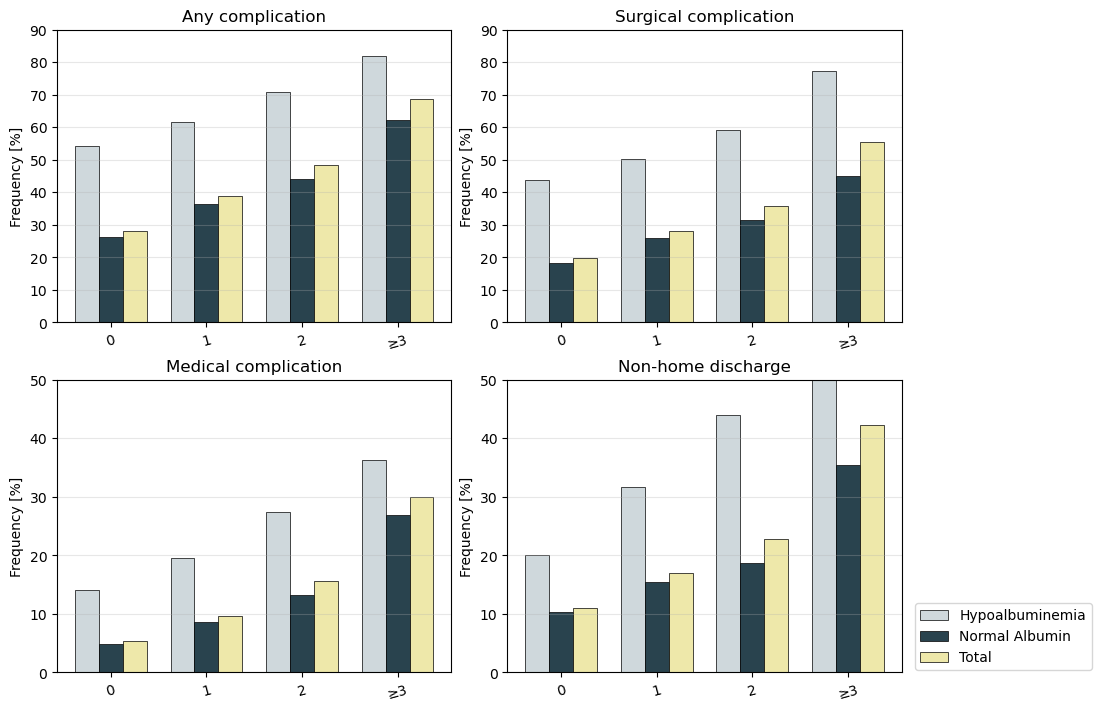

In [47]:
df = df_combined_alb.copy()

category_col = 'mFI_GROUP_3'

# Outcome columns to plot: {column: panel title}
outcomes = {
    'ANYCOMP':   'Any complication',
    'SURGCOMP':  'Surgical complication',
    'MEDCOMP':   'Medical complication',
    'NON_HOME_DC': 'Non-home discharge'
}

# Labels for the three bar groups
labels = ['Hypoalbuminemia', 'Normal Albumin', 'Total']
colors = ['#cfd8dc', '#29434e', '#eee8aa']   # light gray-blue, dark slate, pale khaki

# ----------------------------
# Helper to compute % by group
# ----------------------------
def pct(series):
    """Return percentage (0-100) for a binary 0/1 series, ignoring NaN."""
    return 100.0 * (series == "Yes").mean()

def build_panel_data(df, cat_col, outcome_col):
    """Return categories and a 3xN matrix of percentages for the outcome."""
    cats = pd.Index(sorted(df[cat_col].dropna().unique(), key=lambda x: (str(type(x)), x)))
    res_hypo, res_norm, res_total = [], [], []
    for c in cats:
        dfc = df[df[cat_col] == c]
        res_hypo.append(pct(dfc.loc[dfc['HYPOALB'] == "Yes", outcome_col]))
        res_norm.append(pct(dfc.loc[dfc['HYPOALB'] == "No", outcome_col]))
        res_total.append(pct(dfc[outcome_col]))
    data = np.array([res_hypo, res_norm, res_total])
    return cats.astype(str).tolist(), data

# ----------------------------
# Build the 2x2 plot
# ----------------------------
fig, axes = plt.subplots(2, 2, figsize=(9, 7), constrained_layout=True)
axes = axes.ravel()

for ax, (col, title) in zip(axes, outcomes.items()):
    cats, data = build_panel_data(df, category_col, col)
    n_cats = len(cats)
    x = np.arange(n_cats)
    width = 0.25

    for i in range(3):  # three bar groups
        ax.bar(x + (i-1)*width, data[i], width=width, label=labels[i], color=colors[i], edgecolor='black', linewidth=0.5)

    ax.set_xticks(x)
    ax.set_xticklabels(cats, rotation=15)
    ax.set_ylabel('Frequency [%]')
    ax.set_title(title)
    ax.grid(axis='y', alpha=0.3)

# One legend for all panels
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower left",        # Anchor legend to the left side of the bbox
    bbox_to_anchor=(1.01, 0.05),  # Push legend just outside the right edge
    borderaxespad=0,
    frameon=True
)


# Optional: align y-limits across the top row and bottom row
for ax in axes[:2]:
    ax.set_ylim(0, 90)
for ax in axes[2:]:
    ax.set_ylim(0, 50)

plt.show()


## *Excerpt from Results*

### Figure 3: Correlation between albumin values and complication occurrence. 

#### Step 1: Create figure

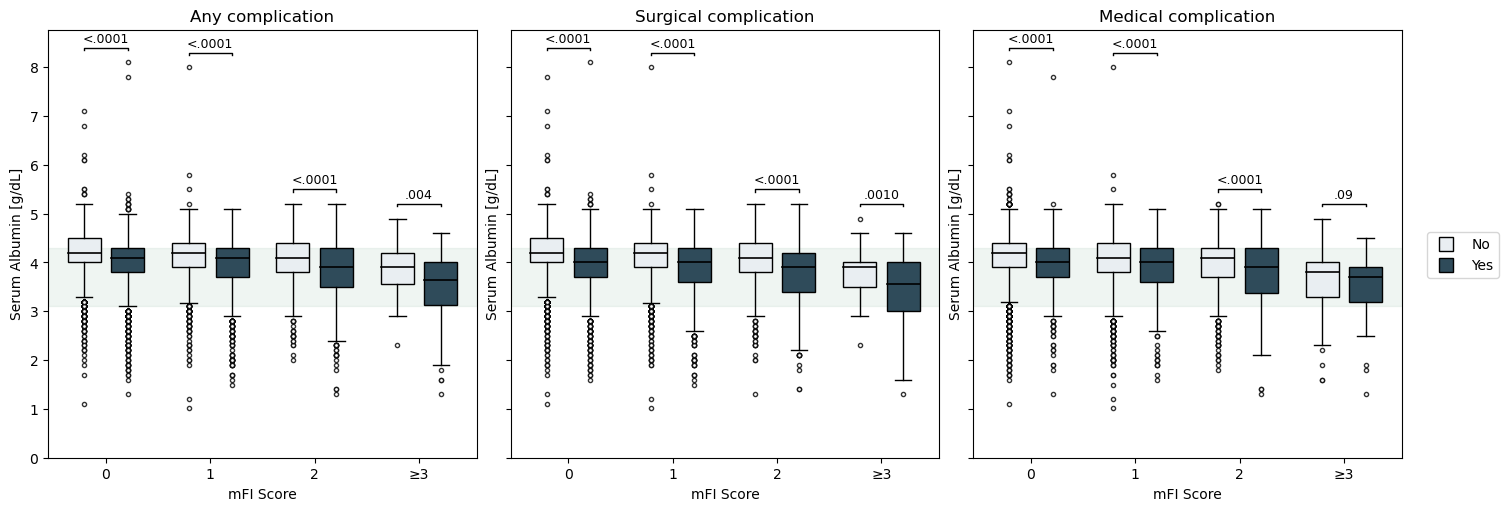

In [48]:
df = df_combined_alb.copy()
albumin_col = "PRALBUM"        # Serum albumin column [g/dL]
mfi_col = "mFI_GROUP_3"          # mFI groups: "0", "1", "2", "≥3"

# Columns to create 3 panels: {column: panel title}
panels = {
    "ANYCOMP": "Any complication",
    "SURGCOMP": "Surgical complication",
    "MEDCOMP": "Medical complication"
}

# Order of mFI groups on the x-axis
mfi_order = ["0", "1", "2", "≥3"]

# Colors for No/Yes
labels = ["No", "Yes"]
facecolors = ["#e9eef2", "#2f4b5a"]  # light gray-blue, dark navy
edgecolor = "black"

# Shaded "normal albumin" band
normal_low, normal_high = 3.1, 4.3
band_alpha = 0.1

# -----------------------------
# Helper Functions
# -----------------------------

def p_format(p):
    """Format p-values like the example figure."""
    if p < 1e-4:
        return "<.0001"
    elif p < 0.001:
        return f"{p:.4f}".replace("0.", ".")
    elif p < 0.01:
        return f"{p:.3f}".replace("0.", ".")
    elif p < 0.1:
        return f"{p:.2f}".lstrip("0")
    return f"{p:.2f}"

def two_sample_p(a, b):
    """Mann–Whitney U test for two independent samples."""
    a = pd.to_numeric(pd.Series(a), errors="coerce").dropna()
    b = pd.to_numeric(pd.Series(b), errors="coerce").dropna()
    if len(a) == 0 or len(b) == 0:
        return np.nan
    try:
        stat, p = stats.mannwhitneyu(a, b, alternative="two-sided")
    except ValueError:
        p = 1.0
    return p

# -----------------------------
# Build Figure
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True, constrained_layout=True)

for ax, (outcome_col, title) in zip(axes, panels.items()):
    # Add shaded band for normal albumin range
    ax.axhspan(normal_low, normal_high, color="#6aa084", alpha=band_alpha, zorder=0)

    positions, boxdata, colors = [], [], []
    gap = 1.2   # spacing between groups
    width = 0.25
    base_x = np.arange(len(mfi_order)) * gap

    # Loop through each mFI group
    for i, mfi in enumerate(mfi_order):
        g = df[df[mfi_col] == mfi]

        # Split by complication outcome
        alb_no = g.loc[g[outcome_col] == "No", albumin_col]
        alb_yes = g.loc[g[outcome_col] == "Yes", albumin_col]

        # Add data for boxplot: No first, Yes second
        boxdata.extend([alb_no, alb_yes])
        positions.extend([base_x[i] - width, base_x[i] + width])
        colors.extend([facecolors[0], facecolors[1]])

        # Calculate p-value and annotate
        p = two_sample_p(alb_no, alb_yes)
        if not np.isnan(p):
            y_max = np.nanmax(pd.concat([alb_no, alb_yes])) if len(alb_no) or len(alb_yes) else np.nan
            if np.isfinite(y_max):
                x0, x1 = base_x[i] - width, base_x[i] + width
                y = y_max + 0.3
                ax.plot([x0, x0, x1, x1], [y - 0.05, y, y, y - 0.05], color="black", lw=1)
                ax.text((x0 + x1) / 2, y + 0.05, p_format(p), ha="center", va="bottom", fontsize=9)

    # Create boxplots
    bp = ax.boxplot(
        boxdata,
        positions=positions,
        widths=0.38,
        patch_artist=True,
        manage_ticks=False,
        medianprops=dict(color="black", linewidth=1.2),
        whiskerprops=dict(color=edgecolor),
        capprops=dict(color=edgecolor),
        boxprops=dict(edgecolor=edgecolor),
        flierprops=dict(marker="o", markersize=3, markerfacecolor="white", markeredgecolor=edgecolor, alpha=0.8),
    )

    # Color boxes manually
    for patch, c in zip(bp["boxes"], colors):
        patch.set_facecolor(c)

    # Axis labels & title
    ax.set_xticks(base_x)
    ax.set_xticklabels(mfi_order)
    ax.set_xlabel("mFI Score")
    ax.set_title(title)
    ax.set_ylabel("Serum Albumin [g/dL]")

# -----------------------------
# Add Legend on Right Side
# -----------------------------
handles = [
    plt.Line2D([0], [0], color=edgecolor, markerfacecolor=facecolors[0], markeredgecolor=edgecolor,
               marker="s", linestyle="", markersize=10, label="No"),
    plt.Line2D([0], [0], color=edgecolor, markerfacecolor=facecolors[1], markeredgecolor=edgecolor,
               marker="s", linestyle="", markersize=10, label="Yes"),
]
fig.legend(handles=handles, loc="center left", bbox_to_anchor=(1.01, 0.5), frameon=True)

plt.ylim(0, None)
plt.show()


## *Excerpt from Results*

### Table 5: Subgroup analysis of albumin values with patients stratified according to complication occurence

#### Reproduction Uncertainty
*In Table 5, the header describes adjusted p-values, but methods do not describe what covariates were adjusted for in this specific table.*

**Decision:** Will present unadjusted p-values.

In [49]:
df = df_combined_alb.copy()
albumin_col = "PRALBUM"
mfi_col     = "mFI_GROUP_3"           # expected labels: "0", "1", "2", "≥3"
mfi_order   = ["0", "1", "2", "≥3"]   # row order (before Total)
panels = {
    "ANYCOMP":  "Any complication",
    "SURGCOMP": "Surgical complication",
    "MEDCOMP":  "Medical complication",
}

# --- helpers ---
def mean_sd_n(x):
    x = pd.to_numeric(pd.Series(x), errors="coerce").dropna()
    if len(x) == 0:
        return np.nan, np.nan, 0
    return x.mean(), x.std(ddof=1), len(x)

def fmt_cell(mean, sd, n):
    if n == 0 or not np.isfinite(mean):
        return "NA\n(0)"
    return f"{mean:.1f} ± {sd:.1f} ({n})"

def p_format(p):
    if not np.isfinite(p): return "NA"
    if p < 1e-4: return "<.0001"
    if p < 0.001: return f"{p:.4f}".replace("0.", ".")
    if p < 0.01:  return f"{p:.3f}".replace("0.", ".")
    if p < 0.1:   return f"{p:.2f}".lstrip("0")
    return f"{p:.2f}"

def mw_p(a, b):
    a = pd.to_numeric(pd.Series(a), errors="coerce").dropna()
    b = pd.to_numeric(pd.Series(b), errors="coerce").dropna()
    if len(a) == 0 or len(b) == 0:
        return np.nan
    try:
        _, p = stats.mannwhitneyu(a, b, alternative="two-sided")
    except ValueError:
        p = 1.0
    return p

def block_for_outcome(df, outcome_col, title, mfi_col, mfi_order):
    rows = []
    index = []
    for grp in mfi_order + ["Total"]:
        g = df if grp == "Total" else df.loc[df[mfi_col] == grp]

        alb_yes = g.loc[g[outcome_col] == "Yes", albumin_col]
        alb_no  = g.loc[g[outcome_col] == "No",  albumin_col]

        my, sy, ny = mean_sd_n(alb_yes)
        mn, sn, nn = mean_sd_n(alb_no)
        pval = mw_p(alb_yes, alb_no)

        rows.append([fmt_cell(my, sy, ny), fmt_cell(mn, sn, nn), p_format(pval)])
        index.append(grp)

    out = pd.DataFrame(rows, index=index, columns=["Yes", "No", "p value"])
    out.index.name = "mFI-5"
    out.columns = pd.MultiIndex.from_product([[title], out.columns])
    return out

# --- build the full table ---
blocks = []
for col, title in panels.items():
    blocks.append(block_for_outcome(df, col, title, mfi_col, mfi_order))

table = pd.concat(blocks, axis=1)
table = table.rename_axis("mFI-5").reset_index()

# pretty display in notebooks
table


mFI-5  Any complication                            Surgical complication  \
                       Yes                 No p value                   Yes   
0      0  4.0 ± 0.5 (2813)   4.2 ± 0.4 (7224)  <.0001      4.0 ± 0.6 (1978)   
1      1  4.0 ± 0.6 (1872)   4.1 ± 0.4 (2953)  <.0001      3.9 ± 0.6 (1361)   
2      2   3.8 ± 0.6 (684)    4.1 ± 0.5 (729)  <.0001       3.8 ± 0.6 (507)   
3     ≥3    3.5 ± 0.7 (94)     3.9 ± 0.5 (43)    .004        3.4 ± 0.7 (76)   
4  Total  4.0 ± 0.6 (5463)  4.2 ± 0.4 (10949)  <.0001      3.9 ± 0.6 (3922)   

                             Medical complication                             
                  No p value                  Yes                 No p value  
0   4.2 ± 0.4 (8059)  <.0001      3.9 ± 0.6 (540)   4.2 ± 0.4 (9497)  <.0001  
1   4.1 ± 0.5 (3464)  <.0001      3.9 ± 0.6 (468)   4.1 ± 0.5 (4357)  <.0001  
2    4.0 ± 0.5 (906)  <.0001      3.8 ± 0.7 (220)   4.0 ± 0.5 (1193)  <.0001  
3     3.8 ± 0.5 (61)   .0010       3.5 ± 0.7 (41)     3.7 ± 0.6 (96)     .09  
4  4.2 ± 0.4 (12490)  <.0001     3.9 ± 0.6 (1269)  4.1 ± 0.5 (15143)  <.0001

## *Excerpt from Methods*

### Statistical Analysis
The analysis was conducted following the Strengthening The Reporting Of Cohort Studies in Surgery (STROCSS) criteria (Mathew
et al., 2021). Univariate statistical analysis was carried out using GraphPad Prism (GraphPad Software 8.00 for MacOS, La Jolla California, USA). Significance was set at p < .05 and p values were adjusted for multiple comparisons using the Bonferroni correction. Differences in categorical variables were assessed using a Chi-square test or Fisher's exact test in cases of expected counts less than five, whereas continuous variables were analyzed using one-way Analysis of Variance (ANOVA) and reported as means with standard deviations. The correlation between albumin levels and mFI score was evaluated by Spearman's R. The albumin levels in the groups with or without any, surgical, and medical complications were further investigated in a
subgroup analysis with values compared using a one-way ANOVA test. Multivariable linear and logistic regression models, incorporating 28 potential demographic and surgical confounders, were employed to identify outcomes independently correlated with the mFI-5 and/or albumin. The results of the multivariate logistic regression for dichotomous outcomes are presented as odds ratios (OR) and 95% confidence intervals (CI), and for continuous outcomes as estimates with 95% CI. The fit of the regression analysis was estimated using the Akaike Information Criterion (AIC) or Adjusted R (Rockwood et al., 2004). Potential confounders were race, sex, age, presence of obesity, underweight status, weight loss >5% in the last 6 months, ASA class,
inpatient setting, smoking status, current dialysis, preoperative ventilator, transfusion, or steroid use, presence of ascites, disseminated cancer, bleeding disorder, sepsis and the preoperative blood values sodium, BUN, creatinine, bilirubin, SGOT, alkaline phosphatase, WBC, hematocrit, platelets, prothrombin time, and INR. Data visualization was conducted in R (Version 4.1.2), GraphPad Prism (GraphPad Software 8.00 for MacOS, La Jolla California, USA), and Adobe Illustrator (2023 for MacOS)

#### Reproduction Uncertainty 
*Original methods do not describe what to do with cases with missing confounders.*

If only cases with confounders present were used, only 75 out of 16,412 cases would remain. 

**Decision**: This model cannot be reproduced. A complete case analysis would only use 75 cases. As much of the missingness comes from the lab values, imputation could be explored, however, there is no mention of imputation in the original paper. 

In [50]:
confounders = [
    "RACE_NEW", "SEX", "Age", "OBESE_BINARY", "UNDERWEIGHT_BINARY", "ASACLAS", "INOUT",
    "SMOKE", "DIALYSIS", "VENTILAT", "TRANSFUS", "STEROID", "ASCITES", "DISCANCR",
    "BLEEDDIS", "PRSEPIS", "PRSODM", "PRBUN", "PRCREAT", "PRBILI", "PRSGOT",
    "PRALKPH", "PRWBC", "PRHCT", "PRPLATE", "PRPTT", "PRINR"
]

# 1) Profile missingness among the present confounders
missing_counts = df_combined_alb[confounders].isna().sum().sort_values(ascending=False)
missing_pct = (df_combined_alb[confounders].isna().mean().sort_values(ascending=False) * 100).round(1)
print("Top missing confounders:\n", pd.concat([missing_counts.rename("n_missing"),
                                               missing_pct.rename("% missing")], axis=1).head(15))

# 2) Compute complete-case counts using only the confounders you actually have
total_cases = len(df_combined_alb)
df_alb_complete = df_combined_alb.dropna(subset=confounders)

remaining_cases = len(df_alb_complete)
dropped_cases = total_cases - remaining_cases
pct_remaining = remaining_cases / total_cases if total_cases else float("nan")

print(f"Total cases: {total_cases}")
print(f"Remaining cases (complete confounder data): {remaining_cases}")
print(f"Dropped due to missing confounders: {dropped_cases}")
print(f"Percentage remaining: {pct_remaining:.2%}")


Top missing confounders:
                     n_missing  % missing
PRSEPIS                 16243       99.0
PRPTT                    9450       57.6
PRINR                    8323       50.7
Age                      2646       16.1
PRSGOT                   1298        7.9
PRBILI                   1190        7.3
PRALKPH                   980        6.0
PRBUN                     451        2.7
PRPLATE                   287        1.7
PRWBC                     273        1.7
PRHCT                     223        1.4
PRSODM                    152        0.9
PRCREAT                   101        0.6
OBESE_BINARY               67        0.4
UNDERWEIGHT_BINARY         67        0.4
Total cases: 16412
Remaining cases (complete confounder data): 75
Dropped due to missing confounders: 16337
Percentage remaining: 0.46%
